In [1]:

import pickle

from utils import *
from multi_threading import read_all_images, parallel_exponentiate_RMS, parallel_sum
from plotting import plot_SUM_or_RMS

# debugging = [True]
configs = dict(debugging=False, 
                  pickle_usage=True, 
                  tiff_amount_cutoff=None
                  )

### Functions

RMS_image_array_csr.pkl 108MB

RMS_image_array.pkl 72MB

In [2]:
"""
Hello world
"""
# Mirror of sum_array_dense()
# Should create a dense sparse matrix output
@timer_decorator(configs)
def get_RMS_array_dense(tiff_path, configs):
    pickle_usage = configs['pickle_usage']
    debugging = configs['debugging']
    
    image_arrays = read_all_images(tiff_path, configs)
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')

    if os.path.exists(f'{tiff_path}\\RMS_image_array.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\RMS_image_array.pkl', 'rb') as f:
            # RMS_array_csr = pickle.load(f)
            RMS_array = pickle.load(f)
        print('Loaded RMS_image_array.pkl')

        # # if RMS_array is csr sparse, convert it to dense
        # if issparse(RMS_array):
        #     RMS_array = RMS_array.toarray()
        #     with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
        #         pickle.dump(RMS_array, f)
    
    else:

        squaring_start_time = time.time()
        # square = [img.power(2) for img in image_arrays]
        square = parallel_exponentiate_RMS(image_arrays, 2)

        squaring_end_time = time.time()
        if debugging==True:
            print(f'Squaring time: {squaring_end_time - squaring_start_time:.1f} seconds. With {get_def_name()}')


        adding_start_time = time.time()
        # RMS_array_csr = (reduce(add, square) / len(square)).power(0.5)
        RMS_array_csr = (parallel_sum(square) / len(square)).power(0.5)

        adding_end_time = time.time()
        if debugging==True:
            print(f'Adding time: {adding_end_time - adding_start_time:.1f} seconds. With {get_def_name()}')


        if debugging==True:
            # print(f'Total RMS_array elements: {RMS_array_csr.size}')    # 开什么玩笑，要吐了！应该直接取Image Dimension!
            _, image_width, image_length = get_tags_from_first_tiff(tiff_path)[:3]
            total_pixel_amount = image_width * image_length
            print(f'Total RMS_array elements: {total_pixel_amount}')
            print(f'Non-zero RMS_array elements: {RMS_array_csr.nnz}')
            print(f'Zero RMS_array elements: {total_pixel_amount - RMS_array_csr.nnz}')


        RMS_array = RMS_array_csr.toarray()
        if pickle_usage==True:
            with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
                pickle.dump(RMS_array, f)

            # with open(f'{tiff_path}\\RMS_image_array_csr.pkl', 'wb') as f:
            #     pickle.dump(RMS_array_csr, f)

    return RMS_array


def get_camera_RMS(RMS_array):
    """
    RMS_array is an array of pixel RMSs
    Calculating RMS of RMS_array is the same as calculating RMS for img_arrays
    """
    return np.sqrt(np.mean(RMS_array**2))


### Testing

Loaded RMS_image_array.pkl


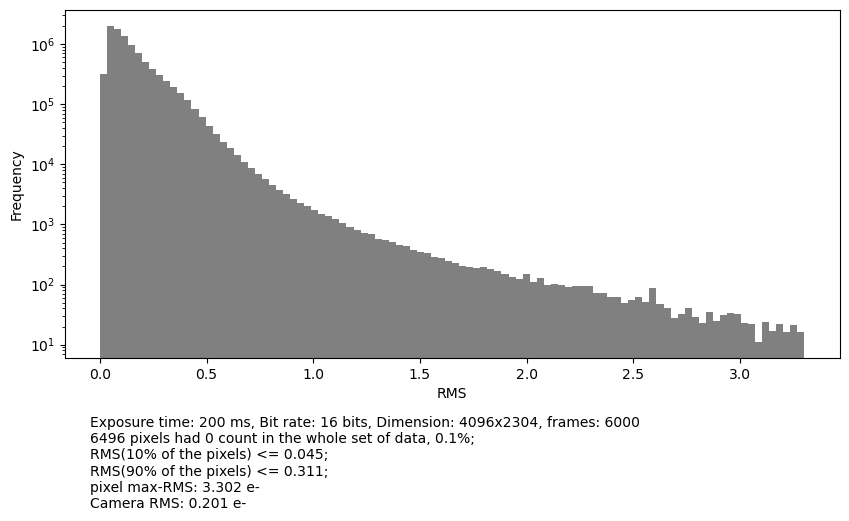

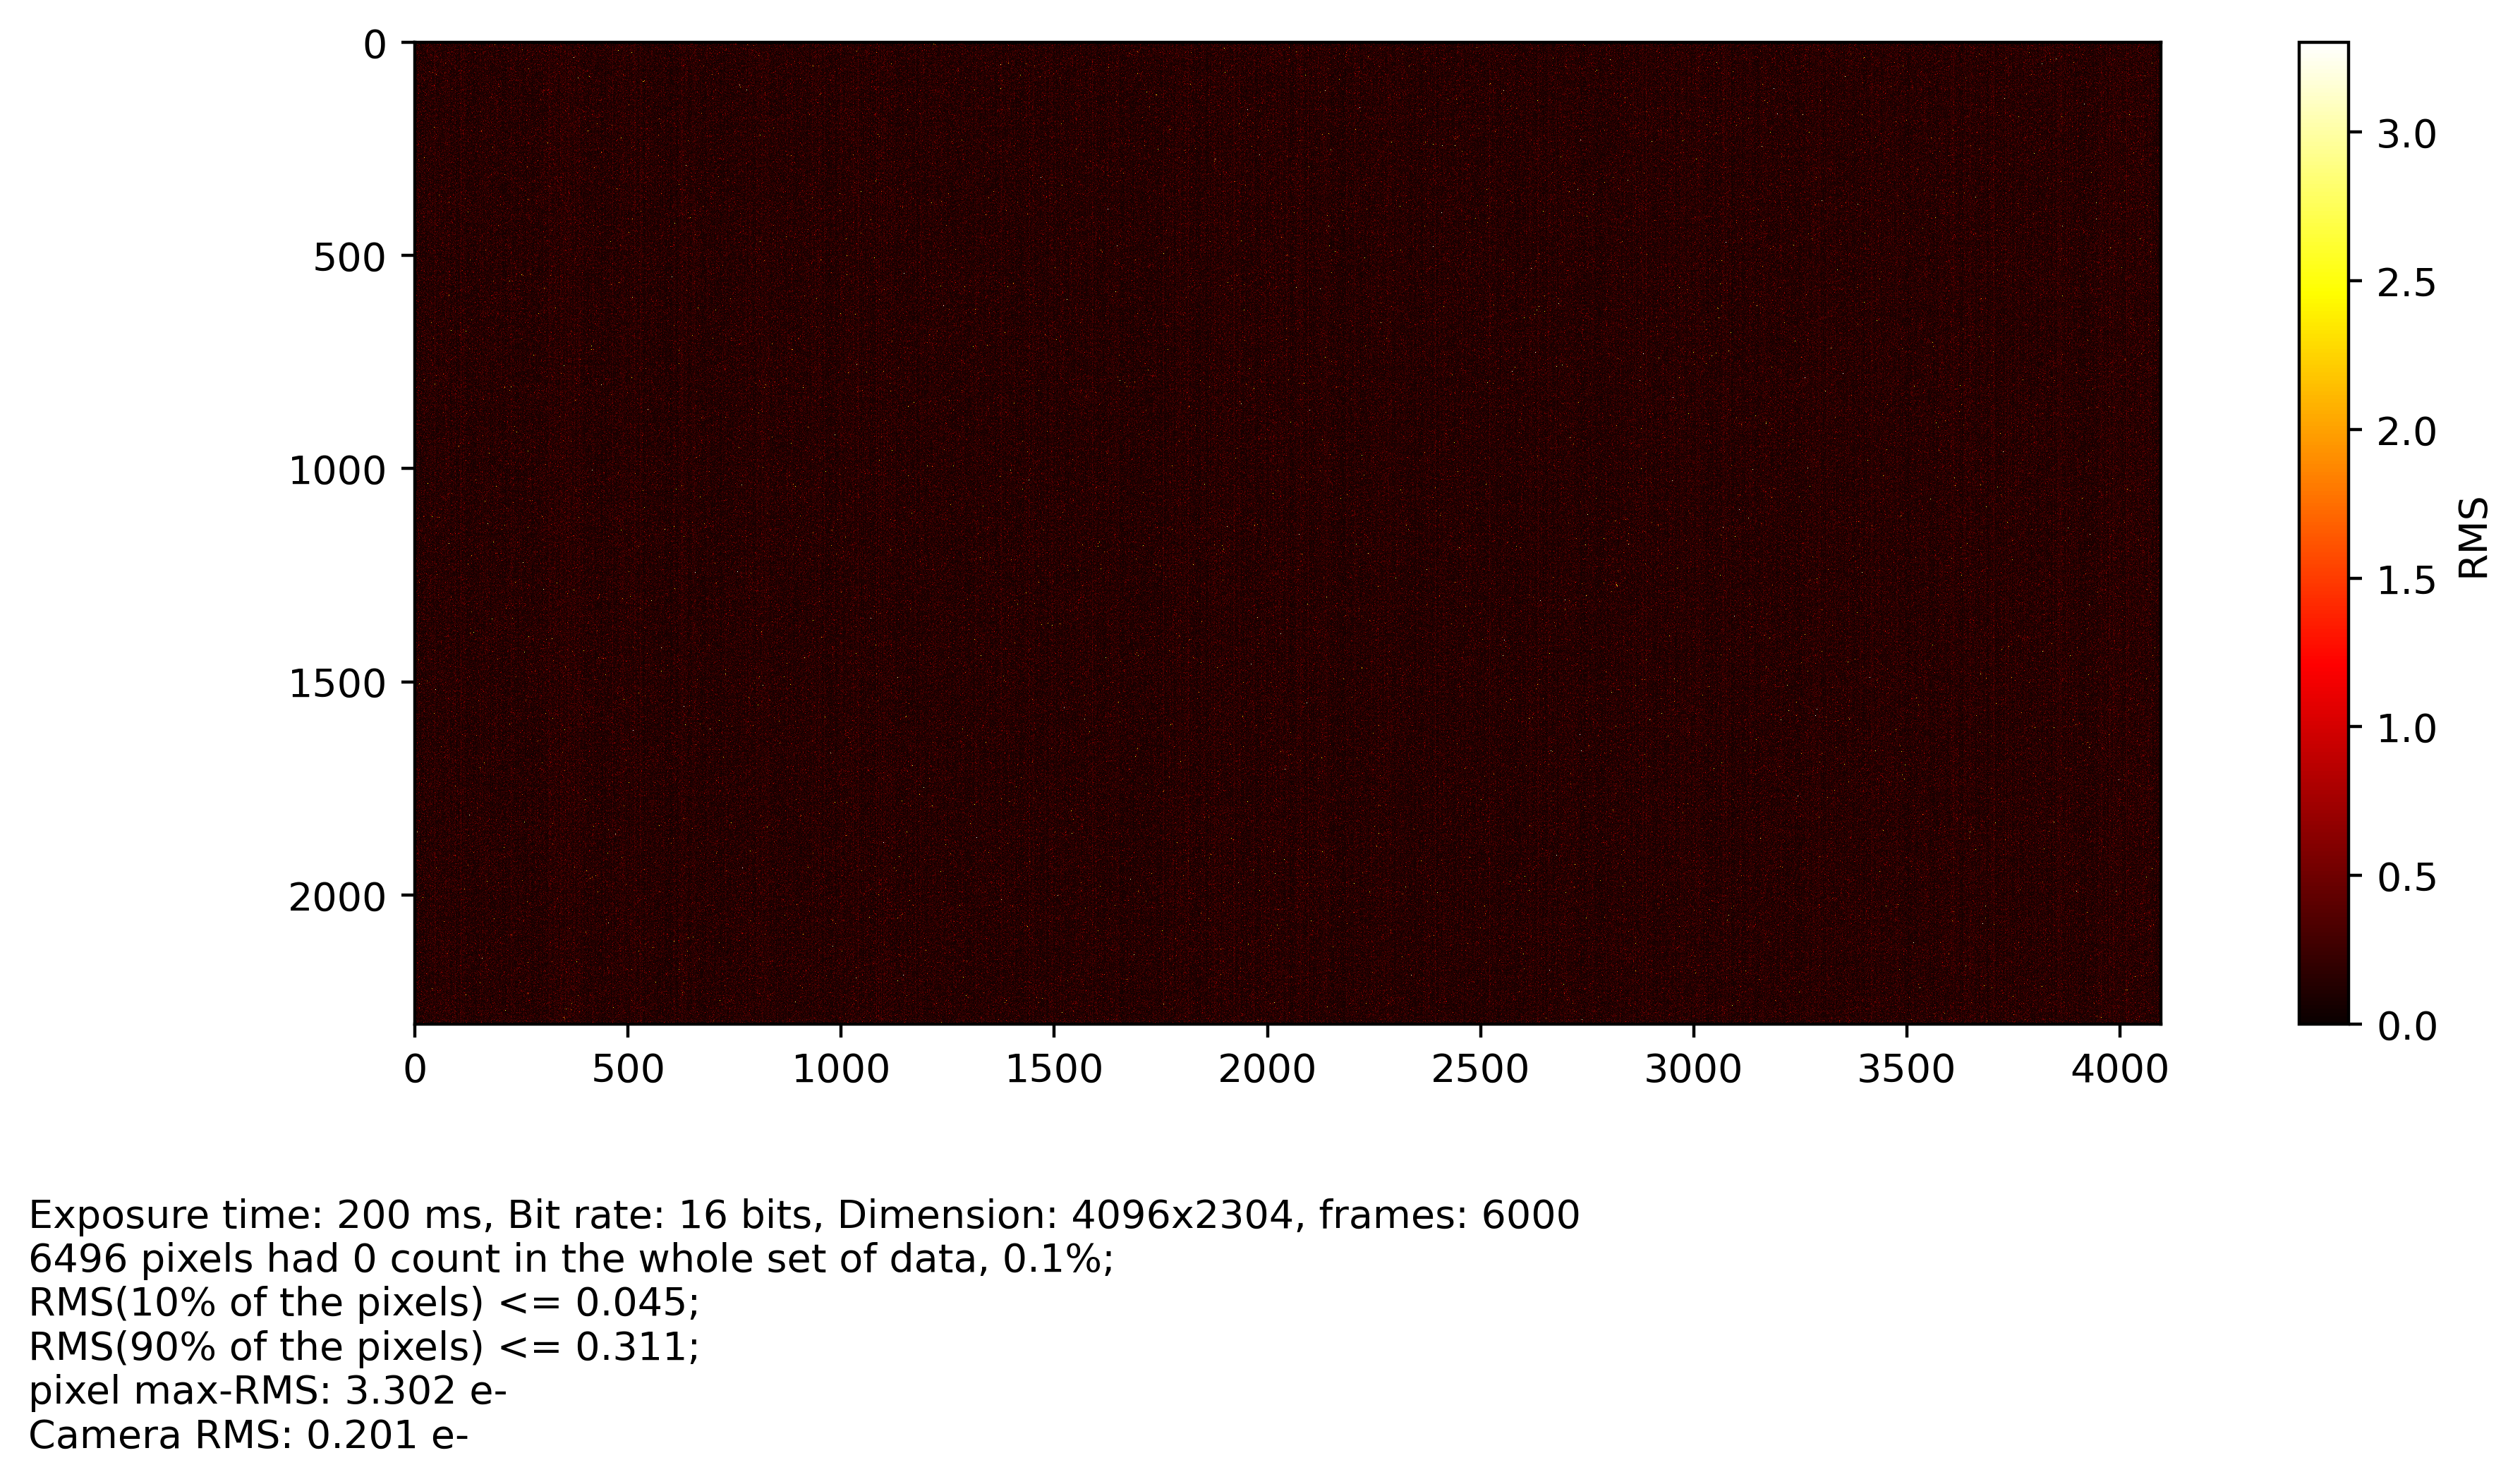

In [4]:
tiff_main_folder = 'C:\\LABDATA_office\\3.12 qCMOS'
# tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_frame_quick'
# tiff_path = tiff_main_folder + '\\full_frame'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# tiff_path = tiff_main_folder + '\\full_5s_2000shots'
# tiff_path = tiff_main_folder + '\\full_5s_6000shots'


RMS_array = get_RMS_array_dense(tiff_path, configs)
# print('Max element:', RMS_array.max())
# print('Min element:', RMS_array.min())
# print('Min non-zero element:', RMS_array[RMS_array > 0].min())

# print(f'issparse(RMS_array)? {issparse(RMS_array)}')
# plot_RMS(RMS_array, tiff_path, plot_type='heat', save=True)
# plot_RMS(RMS_array, tiff_path, plot_type='bar', save=True)
plot_SUM_or_RMS(RMS_array, tiff_path, configs, plot_type='bar', array_type='RMS', save=True)
plot_SUM_or_RMS(RMS_array, tiff_path, configs, plot_type='heat', array_type='RMS', save=True)

In [5]:
# tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# RMS_array_200ms = get_RMS_array_dense(tiff_path, tiff_amount_cutoff=6000, debugging=True)
# cameraRMS_200ms = get_camera_RMS(RMS_array_200ms)

# tiff_path = tiff_main_folder + '\\full_5s_6000shots'
# RMS_array_5000ms = get_RMS_array_dense(tiff_path, tiff_amount_cutoff=6000, debugging=True)
# cameraRMS_5000ms = get_camera_RMS(RMS_array_5000ms)

In [6]:
# # print(f'cameraRMS_200ms:{cameraRMS_200ms} e-')
# # print(f'cameraRMS_5000ms:{cameraRMS_5000ms} e-')
# dark_current = (cameraRMS_5000ms - cameraRMS_200ms) / 4.8
# print(f'Dark current:{dark_current} e-/(pixel*s)')